# Notebook 1: Exploración y Preprocesamiento de Datos

## Contexto del proyecto

Este trabajo forma parte del **Proyecto Final de Aprendizaje No Supervisado**, aplicado a una **base histórica de créditos bancarios**.  
El objetivo global es identificar **patrones y segmentos naturales de riesgo** en la cartera, sin utilizar etiquetas de default, mediante:

- **Reducción de dimensionalidad** (PCA y UMAP)
- **Clustering** (KMeans y DBSCAN)
- **Interpretación de los grupos** en términos de riesgo de crédito y calificación.

Para organizar el análisis, el proyecto se divide en cuatro notebooks:

1. **Notebook 1 – Exploración y preprocesamiento de datos**  ✅ (este notebook)  
2. **Notebook 2 – Reducción de dimensionalidad (PCA y UMAP)**  
3. **Notebook 3 – Clustering (KMeans y DBSCAN + métricas internas)**  
4. **Notebook 4 – Interpretación de clusters y conclusiones de negocio**

---

## Objetivo de este notebook

El objetivo específico de este notebook es dejar un **dataset numérico, limpio y escalado**, listo para aplicar técnicas de reducción de dimensionalidad y clustering en los notebooks siguientes.

Trabajamos sobre el archivo `base_historica.csv` (créditos bancarios) y realizamos:

1. **Carga y exploración inicial del dataset**
   - Dimensiones, tipos de variables y primeras filas.
   - Identificación de variables numéricas, categóricas y de fecha.

2. **Análisis de calidad de datos**
   - Valores faltantes por columna (tabla + gráficos).
   - Detección de filas duplicadas y su tratamiento.
   - Análisis de cardinalidad de variables categóricas.

3. **Análisis exploratorio inicial**
   - Estadísticos descriptivos de variables numéricas.
   - Histogramas y boxplots para entender distribución y outliers.
   - Comentarios sobre sesgo, colas largas y posibles problemas.

4. **Tratamiento de valores faltantes**
   - Eliminación de columnas con porcentaje de nulos muy alto.
   - Imputación de:
     - **Numéricas** con la mediana.
     - **Categóricas** con la moda.

5. **Detección y tratamiento de outliers**
   - Identificación mediante IQR.
   - Winsorización (capping en percentiles 1 y 99) para evitar que valores extremos distorsionen el clustering.

6. **Ingeniería de características de crédito**
   - Variables derivadas como:
     - **Edad del cliente**
     - **Antigüedad de la obligación (meses)**
     - **Meses a vencimiento / sin vencimiento**
     - **Ratios de riesgo** (por ejemplo, `ratio_mora`, `ratio_saldo_limite`)
     - Flags de mora (en mora, mora ≥30, etc.).
   - Imputación de posibles nulos generados en estas nuevas variables.

7. **Limpieza de identificadores y PII**
   - Eliminación de campos como nombre, DUI y otros identificadores que no son útiles para el modelo.

8. **Codificación de variables categóricas**
   - One-Hot Encoding para variables de baja cardinalidad.
   - (En el preprocesamiento previo ya se transformaron todas las variables a formato numérico.)

9. **Escalado y análisis de correlación**
   - Escalado de todas las variables numéricas con **StandardScaler** (media 0, desviación estándar 1).
   - Matriz de correlación para detectar variables redundantes.
   - Eliminación opcional de variables con varianza muy baja o alta multicolinealidad.

10. **Generación del dataset final**
    - Construcción del dataset numérico final para modelado.
    - Exportación de:
      - `data_processed.csv`: datos preparados para PCA/UMAP y clustering.
      - `preprocessing_info.txt`: resumen del preprocesamiento aplicado.

---

## Resultado esperado

Al finalizar este notebook, obtenemos un **dataset estandarizado y sin identificadores**, con variables relevantes de comportamiento crediticio y riesgo, que será utilizado en:

- **Notebook 2:** aplicar PCA y UMAP sobre `data_processed.csv`.
- **Notebook 3:** aplicar KMeans y DBSCAN sobre el espacio reducido.
- **Notebook 4:** interpretar los clusters y extraer insights para la gestión de crédito.


In [ ]:
# Importar librerías necesarias
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import warnings
from scipy import stats # type: ignore
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
import os

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas correctamente")


✓ Librerías importadas correctamente


In [8]:
# Cargar el dataset
try:
    # Asegúrate de que el archivo esté en data/raw/base_historica.csv
    df = pd.read_csv('base_historica.csv')
    print(f"✓ Dataset cargado exitosamente")
    print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo '../data/raw/base_historica.csv'")
    print("Por favor, verifica la ruta del archivo.")


✓ Dataset cargado exitosamente

Dimensiones: 26,559 filas × 24 columnas


In [9]:
# Conversión explícita de columnas de fecha a datetime
date_cols = [
    "FechaCorte",
    "Fecha de Nacimiento",
    "Fecha de Otorgamiento",
    "Fecha de Vencimiento",
    "Fecha de Cancelacion",
]

for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

print("✓ Columnas de fecha convertidas a datetime (si existían)")

df[date_cols].head()


✓ Columnas de fecha convertidas a datetime (si existían)


,FechaCorte,Fecha de Nacimiento,Fecha de Otorgamiento,Fecha de Vencimiento,Fecha de Cancelacion
0,2024-08-31,NaT,2024-01-04,NaT,NaT
1,2024-08-31,1996-04-16,2023-09-10,2026-09-10,NaT
2,2024-08-31,1995-04-04,2023-09-17,NaT,NaT
3,2024-08-31,1982-07-20,2024-04-30,2027-04-30,NaT
4,2024-08-31,1965-11-11,2024-03-16,NaT,NaT


In [10]:
# 3.1 - Primeras filas del dataset
print("=== PRIMERAS 10 FILAS DEL DATASET ===")
df.head(10)


=== PRIMERAS 10 FILAS DEL DATASET ===


,FechaCorte,Tipo de Sujeto,Nombre Completo,DUI,NIT,Fecha de Nacimiento,Sexo,Tipo de obligación,Moneda,Numero de Obligacion,Fecha de Otorgamiento,Fecha de Vencimiento,Periodo de Pago,Estado,Sub-estado,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,Tipo de Deudor,Tipo de Garantia,Fecha de Cancelacion,Calificacion
0,2024-08-31,J,Hnos Sarabia S.L.L.,NaN,1884-478096-248-8,NaT,NaN,TIC,USD,OBL-00001,2024-01-04,NaT,OTR,VIG,VIG,0,9446,4895,0.000,147,DIR,FID,NaT,A1
1,2024-08-31,F,Elías Sans Molins,63092114-5,NaN,1996-04-16,M,MIC,USD,OBL-00002,2023-09-10,2026-09-10,QIN,VIG,VIG,0,16190,12262,0.000,93,DIR,SGR,NaT,A1
2,2024-08-31,F,Daniel Jove-Infante,47228121-5,NaN,1995-04-04,M,TDC,USD,OBL-00003,2023-09-17,NaT,MEN,VIG,VIG,0,19928,12533,0.000,134,DIR,HIP,NaT,A1
3,2024-08-31,F,Montserrat Rivas Múgica,89346343-9,NaN,1982-07-20,M,CON,USD,OBL-00004,2024-04-30,2027-04-30,MEN,VIG,VIG,0,11411,4799,0.000,63,DIR,HIP,NaT,A1
4,2024-08-31,F,Inocencio Marti Portero,23415908-6,NaN,1965-11-11,M,TDC,USD,OBL-00005,2024-03-16,NaT,QIN,VIG,VIG,0,16224,15845,0.000,154,DIR,FID,NaT,A2
5,2024-08-31,F,Plinio Leopoldo Cordero Medina,40835537-2,NaN,2000-04-28,M,TDC,USD,OBL-00006,2024-03-21,NaT,VEN,VIG,VIG,0,1688,854,0.000,57,DIR,FID,NaT,A1
6,2024-08-31,F,Apolonia Reguera Valderrama,86943028-2,NaN,1970-02-21,F,TDC,USD,OBL-00007,2024-05-27,NaT,MEN,VIG,VIG,0,2619,2457,0.000,171,DIR,SGR,NaT,A2
7,2024-08-31,F,Saturnino Oliva,78102805-6,NaN,1998-03-13,M,MIC,USD,OBL-00008,2024-04-10,2026-04-10,QIN,VIG,VIG,0,4042,1797,0.000,182,DIR,HIP,NaT,A1
8,2024-08-31,F,Maristela Cuéllar,32800794-1,NaN,1988-06-04,F,MIC,USD,OBL-00009,2024-04-03,2026-04-03,VEN,VIG,VIG,0,12240,2258,0.000,92,DIR,FID,NaT,A1
9,2024-08-31,F,Renata Fabra Tormo,68319683-1,NaN,1966-07-13,F,CMZ,USD,OBL-00010,2023-10-24,2028-10-24,OTR,VIG,VIG,0,13328,10791,0.000,184,DIR,AVA,NaT,A2


In [11]:
# 3.2 - Información general del dataset
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
df.info()

print("\n=== NOMBRES DE COLUMNAS ===")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


=== INFORMACIÓN GENERAL DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26559 entries, 0 to 26558
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   FechaCorte             26559 non-null  datetime64[ns]
 1   Tipo de Sujeto         26559 non-null  object        
 2   Nombre Completo        26559 non-null  object        
 3   DUI                    23495 non-null  object        
 4   NIT                    3064 non-null   object        
 5   Fecha de Nacimiento    23495 non-null  datetime64[ns]
 6   Sexo                   23495 non-null  object        
 7   Tipo de obligación     26559 non-null  object        
 8   Moneda                 26559 non-null  object        
 9   Numero de Obligacion   26559 non-null  object        
 10  Fecha de Otorgamiento  26559 non-null  datetime64[ns]
 11  Fecha de Vencimiento   15419 non-null  datetime64[ns]
 12  Periodo de Pago     

In [12]:
# 3.3 - Clasificación de variables por tipo

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()

print("=== CLASIFICACIÓN DE VARIABLES ===")

print(f"\n📊 Variables Numéricas ({len(numeric_cols)}):")
for col in numeric_cols:
    print(f"   - {col}")

print(f"\n📝 Variables Categóricas ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"   - {col}")

print(f"\n📅 Variables de Fecha ({len(datetime_cols)}):")
for col in datetime_cols:
    print(f"   - {col}")


=== CLASIFICACIÓN DE VARIABLES ===

📊 Variables Numéricas (5):
   - Numero Dias Mora
   - Valor Limite
   - Valor Saldo Total
   - Valor Mora Total
   - Valor Cuota

📝 Variables Categóricas (14):
   - Tipo de Sujeto
   - Nombre Completo
   - DUI
   - NIT
   - Sexo
   - Tipo de obligación
   - Moneda
   - Numero de Obligacion
   - Periodo de Pago
   - Estado
   - Sub-estado
   - Tipo de Deudor
   - Tipo de Garantia
   - Calificacion

📅 Variables de Fecha (5):
   - FechaCorte
   - Fecha de Nacimiento
   - Fecha de Otorgamiento
   - Fecha de Vencimiento
   - Fecha de Cancelacion


=== ANÁLISIS DE VALORES FALTANTES ===
                 Columna  Valores_Faltantes  Porcentaje
22  Fecha de Cancelacion              26134      98.400
4                    NIT              23495      88.463
11  Fecha de Vencimiento              11140      41.944
3                    DUI               3064      11.537
5    Fecha de Nacimiento               3064      11.537
6                   Sexo               3064      11.537


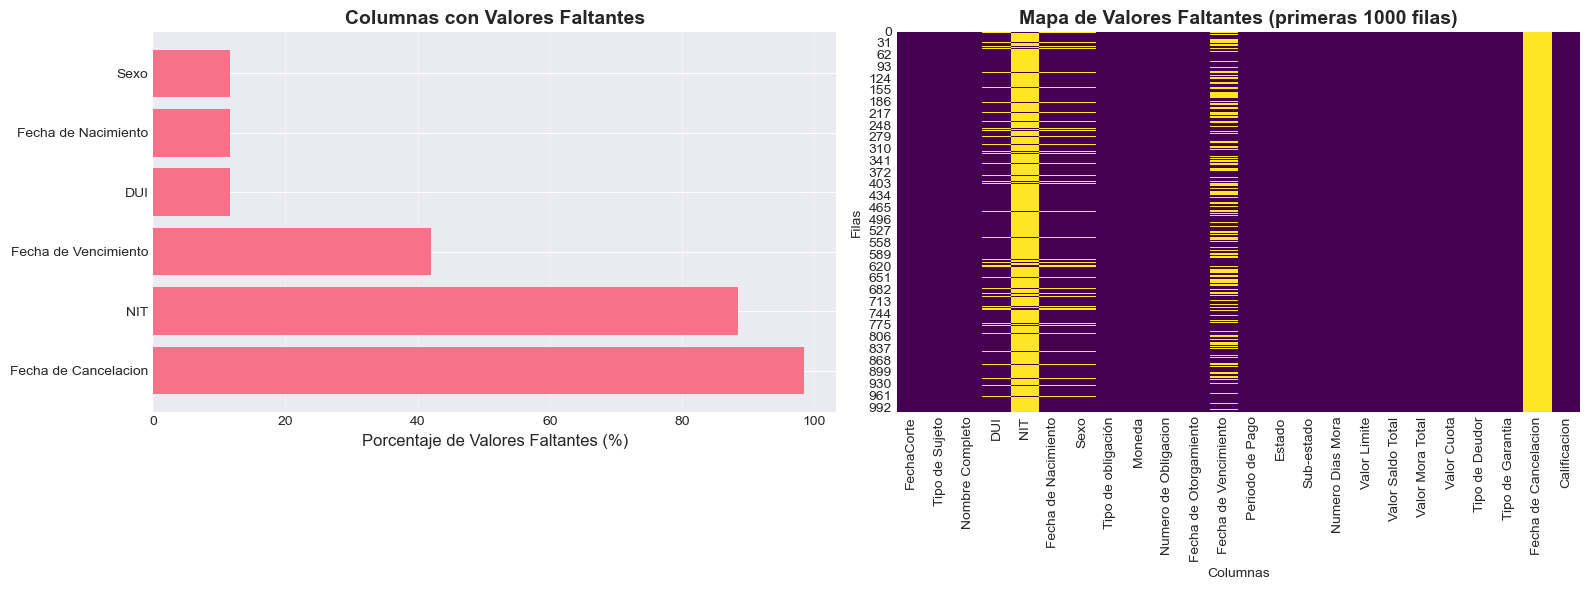

In [13]:
# 3.4 - Análisis de valores faltantes

missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Faltantes': df.isnull().sum().values,
    'Porcentaje': (df.isnull().sum().values / len(df) * 100)
}).sort_values('Porcentaje', ascending=False)

print("=== ANÁLISIS DE VALORES FALTANTES ===")
print(missing_data[missing_data['Valores_Faltantes'] > 0])

# Visualización de valores faltantes
if missing_data['Valores_Faltantes'].sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras (solo columnas con faltantes, máx 20)
    missing_cols = missing_data[missing_data['Valores_Faltantes'] > 0].head(20)
    if len(missing_cols) > 0:
        axes[0].barh(missing_cols['Columna'], missing_cols['Porcentaje'])
        axes[0].set_xlabel('Porcentaje de Valores Faltantes (%)', fontsize=12)
        axes[0].set_title('Columnas con Valores Faltantes', fontsize=14, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
    
    # Heatmap (primeras 1000 filas)
    sample_size = min(1000, len(df))
    sns.heatmap(df.head(sample_size).isnull(), cbar=False, cmap='viridis', ax=axes[1])
    axes[1].set_title('Mapa de Valores Faltantes (primeras 1000 filas)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Columnas')
    axes[1].set_ylabel('Filas')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No hay valores faltantes en el dataset")


In [14]:
# 3.5 - Análisis de duplicados

duplicates = df.duplicated().sum()
print("=== ANÁLISIS DE DUPLICADOS ===")
print(f"Filas duplicadas: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

if duplicates > 0:
    print("\n⚠️ Se encontraron filas duplicadas. Ejemplo:")
    display(df[df.duplicated(keep=False)].head(10))
    
    # Eliminar duplicados
    df_clean = df.drop_duplicates()
    print(f"\n✓ Duplicados eliminados. Nuevas dimensiones: {df_clean.shape}")
else:
    df_clean = df.copy()
    print("\n✓ No se encontraron filas duplicadas")


=== ANÁLISIS DE DUPLICADOS ===
Filas duplicadas: 0 (0.00%)

✓ No se encontraron filas duplicadas


In [15]:
# 3.6 - Cardinalidad de variables categóricas

print("=== CARDINALIDAD DE VARIABLES CATEGÓRICAS ===")

for col in categorical_cols:
    n_unique = df_clean[col].nunique()
    n_missing = df_clean[col].isnull().sum()
    print(f"\n{col}:")
    print(f"  - Valores únicos: {n_unique}")
    print(f"  - Valores faltantes: {n_missing}")
    
    # Si tiene pocas categorías, mostramos la distribución
    if n_unique <= 15:
        print("  - Distribución:")
        value_counts = df_clean[col].value_counts()
        for val, count in value_counts.items():
            print(f"      {val}: {count:,} ({count/len(df_clean)*100:.2f}%)")


=== CARDINALIDAD DE VARIABLES CATEGÓRICAS ===

Tipo de Sujeto:
  - Valores únicos: 2
  - Valores faltantes: 0
  - Distribución:
      F: 23,495 (88.46%)
      J: 3,064 (11.54%)

Nombre Completo:
  - Valores únicos: 2296
  - Valores faltantes: 0

DUI:
  - Valores únicos: 2031
  - Valores faltantes: 3064

NIT:
  - Valores únicos: 265
  - Valores faltantes: 23495

Sexo:
  - Valores únicos: 2
  - Valores faltantes: 3064
  - Distribución:
      M: 14,201 (53.47%)
      F: 9,294 (34.99%)

Tipo de obligación:
  - Valores únicos: 5
  - Valores faltantes: 0
  - Distribución:
      TIC: 5,795 (21.82%)
      TDC: 5,345 (20.13%)
      CMZ: 5,267 (19.83%)
      MIC: 5,226 (19.68%)
      CON: 4,926 (18.55%)

Moneda:
  - Valores únicos: 1
  - Valores faltantes: 0
  - Distribución:
      USD: 26,559 (100.00%)

Numero de Obligacion:
  - Valores únicos: 2296
  - Valores faltantes: 0

Periodo de Pago:
  - Valores únicos: 4
  - Valores faltantes: 0
  - Distribución:
      QIN: 7,167 (26.99%)
      VEN: 7,

In [16]:
# 4.1 - Tratamiento de valores faltantes

print("=== ESTRATEGIA DE TRATAMIENTO DE VALORES FALTANTES ===")

# Partimos de df_clean (sin duplicados)
df_processed = df_clean.copy()

# Recalcular resumen de nulos sobre df_processed
missing_data_proc = pd.DataFrame({
    'Columna': df_processed.columns,
    'Valores_Faltantes': df_processed.isnull().sum().values,
    'Porcentaje': (df_processed.isnull().sum().values / len(df_processed) * 100)
}).sort_values('Porcentaje', ascending=False)

print("\nResumen de nulos (antes de tratamiento):")
print(missing_data_proc[missing_data_proc['Valores_Faltantes'] > 0])

# 1) Eliminar columnas con > 50% de valores faltantes
threshold_drop = 0.5
cols_to_drop = missing_data_proc[missing_data_proc['Porcentaje'] > threshold_drop * 100]['Columna'].tolist()

if cols_to_drop:
    print(f"\n1) Eliminando columnas con > {threshold_drop*100:.0f}% de valores faltantes:")
    for col in cols_to_drop:
        print(f"   - {col}")
    df_processed = df_processed.drop(columns=cols_to_drop)
else:
    print(f"\n1) No hay columnas con > {threshold_drop*100:.0f}% de valores faltantes")

# 2) Imputar numéricas con la mediana
numeric_cols_proc = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_with_missing = [col for col in numeric_cols_proc if df_processed[col].isnull().sum() > 0]

if numeric_cols_with_missing:
    print("\n2) Imputando valores faltantes en numéricas (mediana):")
    for col in numeric_cols_with_missing:
        n_missing = df_processed[col].isnull().sum()
        median_val = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_val)
        print(f"   - {col}: {n_missing} valores imputados con mediana = {median_val:.3f}")
else:
    print("\n2) No hay valores faltantes en variables numéricas")

# 3) Imputar categóricas con la moda
categorical_cols_proc = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_cols_with_missing = [col for col in categorical_cols_proc if df_processed[col].isnull().sum() > 0]

if categorical_cols_with_missing:
    print("\n3) Imputando valores faltantes en categóricas (moda):")
    for col in categorical_cols_with_missing:
        n_missing = df_processed[col].isnull().sum()
        mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else "DESCONOCIDO"
        df_processed[col] = df_processed[col].fillna(mode_value)
        print(f"   - {col}: {n_missing} valores imputados con '{mode_value}'")
else:
    print("\n3) No hay valores faltantes en variables categóricas")

# Verificación final
remaining_missing = df_processed.isnull().sum().sum()
print(f"\n✓ Valores faltantes restantes en todo el dataframe: {remaining_missing}")
print(f"✓ Dimensiones después de tratamiento de nulos: {df_processed.shape}")


=== ESTRATEGIA DE TRATAMIENTO DE VALORES FALTANTES ===

Resumen de nulos (antes de tratamiento):
                 Columna  Valores_Faltantes  Porcentaje
22  Fecha de Cancelacion              26134      98.400
4                    NIT              23495      88.463
11  Fecha de Vencimiento              11140      41.944
3                    DUI               3064      11.537
5    Fecha de Nacimiento               3064      11.537
6                   Sexo               3064      11.537

1) Eliminando columnas con > 50% de valores faltantes:
   - Fecha de Cancelacion
   - NIT

2) No hay valores faltantes en variables numéricas

3) Imputando valores faltantes en categóricas (moda):
   - DUI: 3064 valores imputados con '10302466-8'
   - Sexo: 3064 valores imputados con 'M'

✓ Valores faltantes restantes en todo el dataframe: 14204
✓ Dimensiones después de tratamiento de nulos: (26559, 22)


In [17]:
# 4.2 - Detección de outliers usando el método IQR

print("=== DETECCIÓN DE OUTLIERS (MÉTODO IQR) ===")

# Tomamos solo variables numéricas de df_processed
numeric_cols_current = df_processed.select_dtypes(include=[np.number]).columns.tolist()
print(f"Variables numéricas consideradas: {len(numeric_cols_current)}")

outlier_summary = []

for col in numeric_cols_current:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df_processed)) * 100
    
    outlier_summary.append({
        'Variable': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite_Inferior': lower_bound,
        'Límite_Superior': upper_bound,
        'N_Outliers': n_outliers,
        'Porcentaje': pct_outliers
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Porcentaje', ascending=False)
print(outlier_df)

print(f"\nTotal de outliers detectados (sumando por variable): {outlier_df['N_Outliers'].sum():,}")


=== DETECCIÓN DE OUTLIERS (MÉTODO IQR) ===
Variables numéricas consideradas: 5
            Variable       Q1        Q3      IQR  Límite_Inferior  \
3   Valor Mora Total    0.000   983.400  983.400        -1475.100   
2  Valor Saldo Total 1274.500  5343.000 4068.500        -4828.250   
0   Numero Dias Mora    0.000   140.000  140.000         -210.000   
1       Valor Limite 6085.000 15537.000 9452.000        -8093.000   
4        Valor Cuota   63.000   153.000   90.000          -72.000   

   Límite_Superior  N_Outliers  Porcentaje  
3         2458.500        1169       4.402  
2        11445.750         969       3.648  
0          350.000           4       0.015  
1        29715.000           0       0.000  
4          288.000           0       0.000  

Total de outliers detectados (sumando por variable): 2,142


In [18]:
# 4.3 - Tratamiento de outliers: Winsorización (capping)

print("=== TRATAMIENTO DE OUTLIERS: WINSORIZACIÓN ===")
print("Limitando valores extremos a los percentiles 1 y 99...\n")

# Partimos de df_processed (con nulos tratados)
df_winsorized = df_processed.copy()

for col in numeric_cols_current:
    p01 = df_winsorized[col].quantile(0.01)
    p99 = df_winsorized[col].quantile(0.99)
    
    n_capped_lower = (df_winsorized[col] < p01).sum()
    n_capped_upper = (df_winsorized[col] > p99).sum()
    
    df_winsorized[col] = df_winsorized[col].clip(lower=p01, upper=p99)
    
    if n_capped_lower > 0 or n_capped_upper > 0:
        print(f"{col}:")
        print(f"  - Valores limitados inferiormente: {n_capped_lower}")
        print(f"  - Valores limitados superiormente: {n_capped_upper}")

print("\n✓ Winsorización completada")
print(f"Dimensiones de df_winsorized: {df_winsorized.shape}")


=== TRATAMIENTO DE OUTLIERS: WINSORIZACIÓN ===
Limitando valores extremos a los percentiles 1 y 99...

Numero Dias Mora:
  - Valores limitados inferiormente: 0
  - Valores limitados superiormente: 265
Valor Limite:
  - Valores limitados inferiormente: 255
  - Valores limitados superiormente: 253
Valor Saldo Total:
  - Valores limitados inferiormente: 0
  - Valores limitados superiormente: 266
Valor Mora Total:
  - Valores limitados inferiormente: 0
  - Valores limitados superiormente: 266
Valor Cuota:
  - Valores limitados inferiormente: 254
  - Valores limitados superiormente: 258

✓ Winsorización completada
Dimensiones de df_winsorized: (26559, 22)


In [19]:
# 5.1 - Ingeniería de características (crédito)

print("=== INGENIERÍA DE CARACTERÍSTICAS (CRÉDITO) ===")

# Partimos del dataset con nulos tratados y outliers winsorizados
df_engineered = df_winsorized.copy()

# Asegurar que las columnas de fecha estén en datetime
date_cols = [
    "FechaCorte",
    "Fecha de Nacimiento",
    "Fecha de Otorgamiento",
    "Fecha de Vencimiento",
    "Fecha de Cancelacion",  # puede que ya no exista; se ignora si no está
]
for c in date_cols:
    if c in df_engineered.columns:
        df_engineered[c] = pd.to_datetime(df_engineered[c], errors="coerce")

# 1) Edad del cliente
if "FechaCorte" in df_engineered.columns and "Fecha de Nacimiento" in df_engineered.columns:
    df_engineered["edad"] = (
        (df_engineered["FechaCorte"] - df_engineered["Fecha de Nacimiento"]).dt.days / 365.25
    )

# 2) Antigüedad de la obligación (meses)
if "FechaCorte" in df_engineered.columns and "Fecha de Otorgamiento" in df_engineered.columns:
    df_engineered["antiguedad_meses"] = (
        (df_engineered["FechaCorte"] - df_engineered["Fecha de Otorgamiento"]).dt.days / 30.4
    )

# 3) Meses a vencimiento + flag sin vencimiento
if "FechaCorte" in df_engineered.columns and "Fecha de Vencimiento" in df_engineered.columns:
    df_engineered["meses_a_vencimiento"] = (
        (df_engineered["Fecha de Vencimiento"] - df_engineered["FechaCorte"]).dt.days / 30.4
    )
    df_engineered["sin_vencimiento"] = df_engineered["Fecha de Vencimiento"].isna().astype(int)

# 4) Cuenta cancelada (solo si la columna sobrevivió, en tu caso ya se eliminó)
if "Fecha de Cancelacion" in df_engineered.columns:
    df_engineered["cuenta_cancelada"] = df_engineered["Fecha de Cancelacion"].notna().astype(int)

# 5) Ratios financieros
if "Valor Mora Total" in df_engineered.columns and "Valor Saldo Total" in df_engineered.columns:
    df_engineered["ratio_mora"] = (
        df_engineered["Valor Mora Total"] /
        df_engineered["Valor Saldo Total"].replace({0: np.nan})
    )

if "Valor Saldo Total" in df_engineered.columns and "Valor Limite" in df_engineered.columns:
    df_engineered["ratio_saldo_limite"] = (
        df_engineered["Valor Saldo Total"] /
        df_engineered["Valor Limite"].replace({0: np.nan})
    )

# 6) Flags de mora
if "Numero Dias Mora" in df_engineered.columns:
    df_engineered["en_mora"] = (df_engineered["Numero Dias Mora"] > 0).astype(int)
    df_engineered["mora_30"] = (df_engineered["Numero Dias Mora"] >= 30).astype(int)
    df_engineered["mora_90"] = (df_engineered["Numero Dias Mora"] >= 90).astype(int)

# 7) Imputar posibles nulos generados en nuevas columnas numéricas
cols_new = [
    "edad",
    "antiguedad_meses",
    "meses_a_vencimiento",
    "ratio_mora",
    "ratio_saldo_limite",
]
for col in cols_new:
    if col in df_engineered.columns:
        df_engineered[col] = df_engineered[col].astype(float)
        df_engineered[col] = df_engineered[col].fillna(df_engineered[col].median())

print(f"✓ Dimensiones después de ingeniería de características: {df_engineered.shape}")
df_engineered.head()


=== INGENIERÍA DE CARACTERÍSTICAS (CRÉDITO) ===
✓ Dimensiones después de ingeniería de características: (26559, 31)


,FechaCorte,Tipo de Sujeto,Nombre Completo,DUI,Fecha de Nacimiento,Sexo,Tipo de obligación,Moneda,Numero de Obligacion,Fecha de Otorgamiento,Fecha de Vencimiento,Periodo de Pago,Estado,Sub-estado,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,Tipo de Deudor,Tipo de Garantia,Calificacion,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,en_mora,mora_30,mora_90
0,2024-08-31,J,Hnos Sarabia S.L.L.,10302466-8,NaT,M,TIC,USD,OBL-00001,2024-01-04,NaT,OTR,VIG,VIG,0,9446,4895.000,0.000,147,DIR,FID,A1,39.589,7.895,29.901,1,0.000,0.518,0,0,0
1,2024-08-31,F,Elías Sans Molins,63092114-5,1996-04-16,M,MIC,USD,OBL-00002,2023-09-10,2026-09-10,QIN,VIG,VIG,0,16190,12262.000,0.000,93,DIR,SGR,A1,28.375,11.711,24.342,0,0.000,0.757,0,0,0
2,2024-08-31,F,Daniel Jove-Infante,47228121-5,1995-04-04,M,TDC,USD,OBL-00003,2023-09-17,NaT,MEN,VIG,VIG,0,19794,12533.000,0.000,134,DIR,HIP,A1,29.410,11.480,29.901,1,0.000,0.633,0,0,0
3,2024-08-31,F,Montserrat Rivas Múgica,89346343-9,1982-07-20,M,CON,USD,OBL-00004,2024-04-30,2027-04-30,MEN,VIG,VIG,0,11411,4799.000,0.000,63,DIR,HIP,A1,42.116,4.046,31.974,0,0.000,0.421,0,0,0
4,2024-08-31,F,Inocencio Marti Portero,23415908-6,1965-11-11,M,TDC,USD,OBL-00005,2024-03-16,NaT,QIN,VIG,VIG,0,16224,14381.100,0.000,154,DIR,FID,A2,58.804,5.526,29.901,1,0.000,0.886,0,0,0


In [20]:
# 6.1 - Identificar variables categóricas para codificar

print("=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===")

# Columnas categóricas actuales (tipo object)
categorical_cols_current = df_engineered.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables categóricas detectadas ({len(categorical_cols_current)}):")
for col in categorical_cols_current:
    print(f"  - {col} ({df_engineered[col].nunique()} categorías)")


=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===

Variables categóricas detectadas (13):
  - Tipo de Sujeto (2 categorías)
  - Nombre Completo (2296 categorías)
  - DUI (2031 categorías)
  - Sexo (2 categorías)
  - Tipo de obligación (5 categorías)
  - Moneda (1 categorías)
  - Numero de Obligacion (2296 categorías)
  - Periodo de Pago (4 categorías)
  - Estado (2 categorías)
  - Sub-estado (6 categorías)
  - Tipo de Deudor (1 categorías)
  - Tipo de Garantia (4 categorías)
  - Calificacion (8 categorías)


In [22]:
# 6.2 - Eliminar columnas identificadoras / PII antes de codificar

print("=== LIMPIEZA DE COLUMNAS IDENTIFICADORAS/PII ===")

cols_pii = []
for col in ["Nombre Completo", "DUI"]:
    if col in df_engineered.columns:
        cols_pii.append(col)

print(f"Columnas PII a eliminar: {cols_pii}")

# Creamos un dataframe de trabajo para el modelo
df_model = df_engineered.drop(columns=cols_pii) if cols_pii else df_engineered.copy()

# Guardamos el identificador de la obligación aparte (por si después queremos usarlo)
id_column = None
if "Numero de Obligacion" in df_model.columns:
    id_column = df_model["Numero de Obligacion"].copy()
    print("✓ Columna 'Numero de Obligacion' se conservará solo como ID (no como feature).")

print(f"Dimensiones de df_model: {df_model.shape}")
df_model.head()



=== LIMPIEZA DE COLUMNAS IDENTIFICADORAS/PII ===
Columnas PII a eliminar: ['Nombre Completo', 'DUI']
✓ Columna 'Numero de Obligacion' se conservará solo como ID (no como feature).
Dimensiones de df_model: (26559, 29)


,FechaCorte,Tipo de Sujeto,Fecha de Nacimiento,Sexo,Tipo de obligación,Moneda,Numero de Obligacion,Fecha de Otorgamiento,Fecha de Vencimiento,Periodo de Pago,Estado,Sub-estado,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,Tipo de Deudor,Tipo de Garantia,Calificacion,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,en_mora,mora_30,mora_90
0,2024-08-31,J,NaT,M,TIC,USD,OBL-00001,2024-01-04,NaT,OTR,VIG,VIG,0,9446,4895.000,0.000,147,DIR,FID,A1,39.589,7.895,29.901,1,0.000,0.518,0,0,0
1,2024-08-31,F,1996-04-16,M,MIC,USD,OBL-00002,2023-09-10,2026-09-10,QIN,VIG,VIG,0,16190,12262.000,0.000,93,DIR,SGR,A1,28.375,11.711,24.342,0,0.000,0.757,0,0,0
2,2024-08-31,F,1995-04-04,M,TDC,USD,OBL-00003,2023-09-17,NaT,MEN,VIG,VIG,0,19794,12533.000,0.000,134,DIR,HIP,A1,29.410,11.480,29.901,1,0.000,0.633,0,0,0
3,2024-08-31,F,1982-07-20,M,CON,USD,OBL-00004,2024-04-30,2027-04-30,MEN,VIG,VIG,0,11411,4799.000,0.000,63,DIR,HIP,A1,42.116,4.046,31.974,0,0.000,0.421,0,0,0
4,2024-08-31,F,1965-11-11,M,TDC,USD,OBL-00005,2024-03-16,NaT,QIN,VIG,VIG,0,16224,14381.100,0.000,154,DIR,FID,A2,58.804,5.526,29.901,1,0.000,0.886,0,0,0


In [23]:
# 6.3 - Codificación de variables categóricas (One-Hot + Label Encoding)

print("=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS (df_model) ===")

# Detectar columnas categóricas en df_model
categorical_cols_model = df_model.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables categóricas a codificar ({len(categorical_cols_model)}):")
for col in categorical_cols_model:
    print(f"  - {col} ({df_model[col].nunique()} categorías)")

# Copia de trabajo
df_encoded = df_model.copy()

from sklearn.preprocessing import LabelEncoder

label_encoded_cols = []
onehot_encoded_cols = []

for col in categorical_cols_model:
    n_unique = df_encoded[col].nunique()
    
    # Muchas categorías → Label Encoding
    if n_unique > 10:
        le = LabelEncoder()
        df_encoded[f"{col}_encoded"] = le.fit_transform(df_encoded[col].astype(str))
        label_encoded_cols.append(col)
        print(f"\n✓ Label Encoding aplicado a '{col}' ({n_unique} categorías)")
    
    # Pocas categorías → One-Hot Encoding
    else:
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        onehot_encoded_cols.append(col)
        print(f"\n✓ One-Hot Encoding aplicado a '{col}' ({n_unique} categorías → {dummies.shape[1]} columnas nuevas)")

# Eliminar columnas categóricas originales
df_encoded = df_encoded.drop(columns=categorical_cols_model)

print("\nResumen codificación:")
print(f"  - Variables con Label Encoding: {label_encoded_cols}")
print(f"  - Variables con One-Hot Encoding: {onehot_encoded_cols}")
print(f"\n✓ Dimensiones de df_encoded: {df_encoded.shape}")
df_encoded.head()


=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS (df_model) ===

Variables categóricas a codificar (11):
  - Tipo de Sujeto (2 categorías)
  - Sexo (2 categorías)
  - Tipo de obligación (5 categorías)
  - Moneda (1 categorías)
  - Numero de Obligacion (2296 categorías)
  - Periodo de Pago (4 categorías)
  - Estado (2 categorías)
  - Sub-estado (6 categorías)
  - Tipo de Deudor (1 categorías)
  - Tipo de Garantia (4 categorías)
  - Calificacion (8 categorías)

✓ One-Hot Encoding aplicado a 'Tipo de Sujeto' (2 categorías → 1 columnas nuevas)

✓ One-Hot Encoding aplicado a 'Sexo' (2 categorías → 1 columnas nuevas)

✓ One-Hot Encoding aplicado a 'Tipo de obligación' (5 categorías → 4 columnas nuevas)

✓ One-Hot Encoding aplicado a 'Moneda' (1 categorías → 0 columnas nuevas)

✓ Label Encoding aplicado a 'Numero de Obligacion' (2296 categorías)

✓ One-Hot Encoding aplicado a 'Periodo de Pago' (4 categorías → 3 columnas nuevas)

✓ One-Hot Encoding aplicado a 'Estado' (2 categorías → 1 columnas nueva

,FechaCorte,Fecha de Nacimiento,Fecha de Otorgamiento,Fecha de Vencimiento,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,en_mora,mora_30,mora_90,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Numero de Obligacion_encoded,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,2024-08-31,NaT,2024-01-04,NaT,0,9446,4895.000,0.000,147,39.589,7.895,29.901,1,0.000,0.518,0,0,0,True,True,False,False,False,True,0,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
1,2024-08-31,1996-04-16,2023-09-10,2026-09-10,0,16190,12262.000,0.000,93,28.375,11.711,24.342,0,0.000,0.757,0,0,0,False,True,False,True,False,False,1,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
2,2024-08-31,1995-04-04,2023-09-17,NaT,0,19794,12533.000,0.000,134,29.410,11.480,29.901,1,0.000,0.633,0,0,0,False,True,False,False,True,False,2,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
3,2024-08-31,1982-07-20,2024-04-30,2027-04-30,0,11411,4799.000,0.000,63,42.116,4.046,31.974,0,0.000,0.421,0,0,0,False,True,True,False,False,False,3,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,2024-08-31,1965-11-11,2024-03-16,NaT,0,16224,14381.100,0.000,154,58.804,5.526,29.901,1,0.000,0.886,0,0,0,False,True,False,False,True,False,4,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False


In [24]:
# 7.1 - Normalización y escalado (StandardScaler)

from sklearn.preprocessing import StandardScaler

print("=== NORMALIZACIÓN Y ESCALADO ===")

# Todas las columnas numéricas (en df_encoded deben ser todas)
numeric_cols_final = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
print(f"Columnas numéricas a escalar: {len(numeric_cols_final)}")

scaler = StandardScaler()

df_scaled = df_encoded.copy()
df_scaled[numeric_cols_final] = scaler.fit_transform(df_encoded[numeric_cols_final])

print("\n✓ StandardScaler aplicado (media≈0, std≈1)")
print(f"Dimensiones de df_scaled: {df_scaled.shape}")

# Verificación rápida del escalado en las primeras 5 columnas
df_scaled[numeric_cols_final[:5]].describe()


=== NORMALIZACIÓN Y ESCALADO ===
Columnas numéricas a escalar: 15

✓ StandardScaler aplicado (media≈0, std≈1)
Dimensiones de df_scaled: (26559, 44)


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota
count,26559.000,26559.000,26559.000,26559.000,26559.000
mean,-0.000,-0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000
min,-0.927,-1.719,-1.174,-0.801,-1.846
25%,-0.927,-0.846,-0.777,-0.801,-0.845
50%,-0.364,0.005,-0.308,-0.381,-0.013
75%,0.823,0.882,0.492,0.435,0.856
max,2.347,1.660,3.311,3.576,1.876


=== ANÁLISIS DE CORRELACIÓN ===
Dimensión de la matriz de correlación: (15, 15)


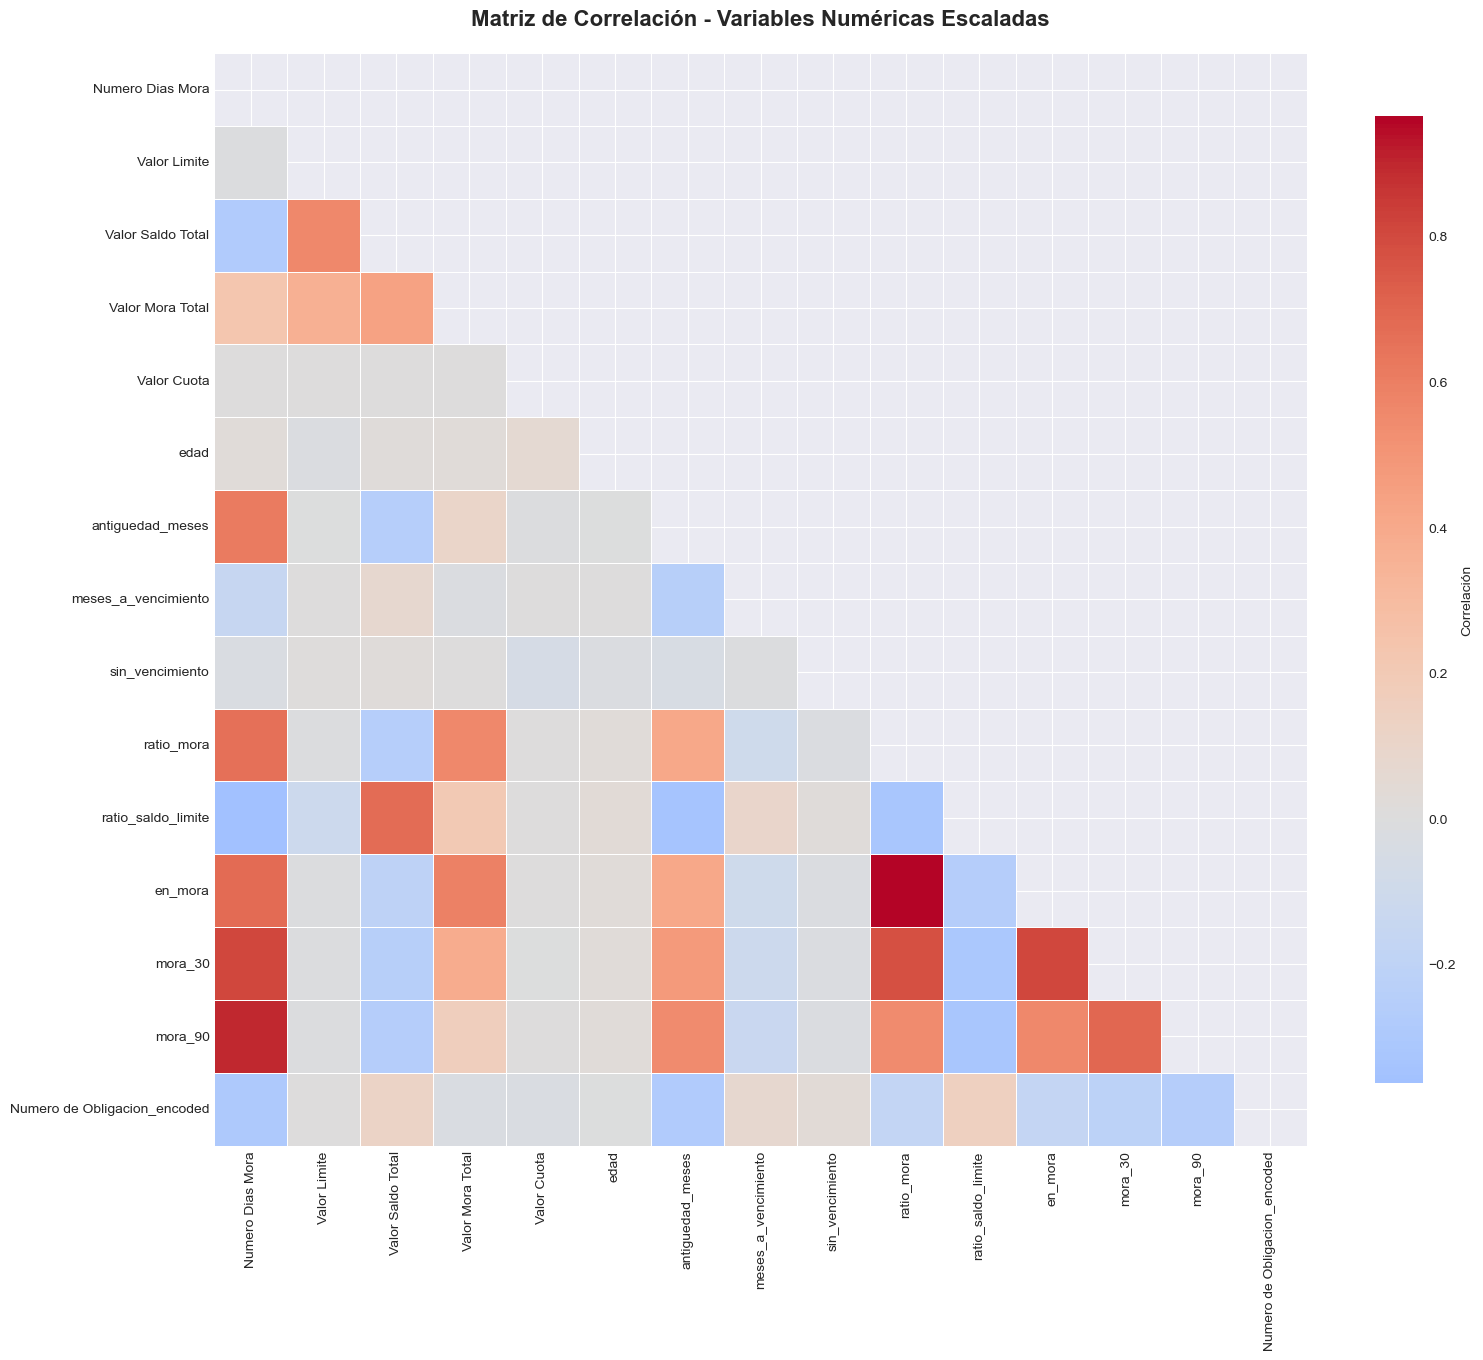

In [25]:
# 7.2 - Análisis de correlación entre variables numéricas

print("=== ANÁLISIS DE CORRELACIÓN ===")

# Matriz de correlación usando df_scaled
correlation_matrix = df_scaled[numeric_cols_final].corr()

print("Dimensión de la matriz de correlación:", correlation_matrix.shape)

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlación"}
)

plt.title("Matriz de Correlación - Variables Numéricas Escaladas", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()


In [26]:
# 7.3 - Identificar pares de variables altamente correlacionadas

print("=== VARIABLES ALTAMENTE CORRELACIONADAS (|r| > 0.85) ===")

threshold_high_corr = 0.85
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        r = correlation_matrix.iloc[i, j]
        if abs(r) > threshold_high_corr:
            high_corr_pairs.append(
                (correlation_matrix.columns[i],
                 correlation_matrix.columns[j],
                 r)
            )

if high_corr_pairs:
    for v1, v2, r in high_corr_pairs:
        print(f"  • {v1:30s} <-> {v2:30s}: {r:6.3f}")
    print(f"\nTotal de pares con |r| > {threshold_high_corr}: {len(high_corr_pairs)}")
else:
    print(f"No se encontraron pares con |r| > {threshold_high_corr}")


=== VARIABLES ALTAMENTE CORRELACIONADAS (|r| > 0.85) ===
  • Numero Dias Mora               <-> mora_90                       :  0.897
  • ratio_mora                     <-> en_mora                       :  0.965

Total de pares con |r| > 0.85: 2


In [27]:
# 8.1 - Construcción del dataset final de características para PCA/UMAP y clustering

print("=== SELECCIÓN FINAL DE CARACTERÍSTICAS ===")

df_final = df_scaled.copy()

cols_to_remove = []

# 1) Quitar ID codificado (no es una feature real)
if "Numero de Obligacion_encoded" in df_final.columns:
    cols_to_remove.append("Numero de Obligacion_encoded")

# 2) De los pares muy correlacionados, quitamos las variables más redundantes
#    - Numero Dias Mora vs mora_90 -> nos quedamos con Numero Dias Mora (más granular)
if "mora_90" in df_final.columns:
    cols_to_remove.append("mora_90")

#    - ratio_mora vs en_mora -> nos quedamos con ratio_mora (variable continua)
if "en_mora" in df_final.columns:
    cols_to_remove.append("en_mora")

print(f"Columnas a eliminar por redundancia/ID: {cols_to_remove}")

df_final = df_final.drop(columns=cols_to_remove)
print(f"\nDimensiones de df_scaled: {df_scaled.shape}")
print(f"Dimensiones de df_final (sin redundantes): {df_final.shape}")

df_final.head()


=== SELECCIÓN FINAL DE CARACTERÍSTICAS ===
Columnas a eliminar por redundancia/ID: ['Numero de Obligacion_encoded', 'mora_90', 'en_mora']

Dimensiones de df_scaled: (26559, 44)
Dimensiones de df_final (sin redundantes): (26559, 41)


,FechaCorte,Fecha de Nacimiento,Fecha de Otorgamiento,Fecha de Vencimiento,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,2024-08-31,NaT,2024-01-04,NaT,-0.927,-0.232,0.353,-0.801,0.743,0.039,-0.858,-0.016,1.176,-1.413,0.693,-1.098,True,True,False,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
1,2024-08-31,1996-04-16,2023-09-10,2026-09-10,-0.927,1.001,2.650,-0.801,-0.278,-0.926,0.007,-0.537,-0.850,-1.413,1.773,-1.098,False,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
2,2024-08-31,1995-04-04,2023-09-17,NaT,-0.927,1.660,2.735,-0.801,0.497,-0.837,-0.045,-0.016,1.176,-1.413,1.213,-1.098,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
3,2024-08-31,1982-07-20,2024-04-30,2027-04-30,-0.927,0.128,0.323,-0.801,-0.845,0.257,-1.730,0.178,-0.850,-1.413,0.252,-1.098,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,2024-08-31,1965-11-11,2024-03-16,NaT,-0.927,1.007,3.311,-0.801,0.875,1.693,-1.394,-0.016,1.176,-1.413,2.356,-1.098,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False


In [28]:
# 8.2 - Eliminar columnas de fecha originales (ya tenemos edad/antigüedad/etc.)

print("=== ELIMINANDO COLUMNAS DE FECHA ORIGINALES ===")

date_cols_to_drop = [
    "FechaCorte",
    "Fecha de Nacimiento",
    "Fecha de Otorgamiento",
    "Fecha de Vencimiento",
]

date_cols_to_drop = [c for c in date_cols_to_drop if c in df_final.columns]

print(f"Columnas de fecha a eliminar: {date_cols_to_drop}")

df_features = df_final.drop(columns=date_cols_to_drop)

print(f"\nDimensiones de df_final:   {df_final.shape}")
print(f"Dimensiones de df_features (solo numéricas para PCA/UMAP): {df_features.shape}")

df_features.head()


=== ELIMINANDO COLUMNAS DE FECHA ORIGINALES ===
Columnas de fecha a eliminar: ['FechaCorte', 'Fecha de Nacimiento', 'Fecha de Otorgamiento', 'Fecha de Vencimiento']

Dimensiones de df_final:   (26559, 41)
Dimensiones de df_features (solo numéricas para PCA/UMAP): (26559, 37)


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,-0.927,-0.232,0.353,-0.801,0.743,0.039,-0.858,-0.016,1.176,-1.413,0.693,-1.098,True,True,False,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
1,-0.927,1.001,2.650,-0.801,-0.278,-0.926,0.007,-0.537,-0.850,-1.413,1.773,-1.098,False,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
2,-0.927,1.660,2.735,-0.801,0.497,-0.837,-0.045,-0.016,1.176,-1.413,1.213,-1.098,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
3,-0.927,0.128,0.323,-0.801,-0.845,0.257,-1.730,0.178,-0.850,-1.413,0.252,-1.098,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,-0.927,1.007,3.311,-0.801,0.875,1.693,-1.394,-0.016,1.176,-1.413,2.356,-1.098,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False


In [29]:
# 9.1 - Conversión de booleanos y exportación de datos procesados
print("=== EXPORTACIÓN DE DATOS PROCESADOS ===")

# Copia para exportación
df_export = df_features.copy()

# Convertir columnas booleanas a 0/1 (int), por claridad
bool_cols = df_export.select_dtypes(include=["bool"]).columns.tolist()
print(f"Columnas booleanas a convertir en 0/1: {bool_cols}")

for col in bool_cols:
    df_export[col] = df_export[col].astype(int)

print("\nTipos de datos finales:")
print(df_export.dtypes.head(15))

# 👉 Guardar en la MISMA carpeta del notebook
# (ML_Final_Project/notebooks/data_processed.csv)
processed_dir = "."   # carpeta actual (donde está el notebook)

output_path = os.path.join(processed_dir, "data_processed.csv")
df_export.to_csv(output_path, index=False)

print(f"\n✓ Dataset procesado guardado en: {output_path}")
print(f"✓ Forma final de df_export: {df_export.shape}")

# Vista rápida de las primeras filas
df_export.head()


=== EXPORTACIÓN DE DATOS PROCESADOS ===
Columnas booleanas a convertir en 0/1: ['Tipo de Sujeto_J', 'Sexo_M', 'Tipo de obligación_CON', 'Tipo de obligación_MIC', 'Tipo de obligación_TDC', 'Tipo de obligación_TIC', 'Periodo de Pago_OTR', 'Periodo de Pago_QIN', 'Periodo de Pago_VEN', 'Estado_VIG', 'Sub-estado_CJU', 'Sub-estado_MOR', 'Sub-estado_VEN', 'Sub-estado_VIG', 'Sub-estado_VOL', 'Tipo de Garantia_FID', 'Tipo de Garantia_HIP', 'Tipo de Garantia_SGR', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E']

Tipos de datos finales:
Numero Dias Mora          float64
Valor Limite              float64
Valor Saldo Total         float64
Valor Mora Total          float64
Valor Cuota               float64
edad                      float64
antiguedad_meses          float64
meses_a_vencimiento       float64
sin_vencimiento           float64
ratio_mora                float64
ratio_saldo_limite        float64
mora_30    

,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,-0.927,-0.232,0.353,-0.801,0.743,0.039,-0.858,-0.016,1.176,-1.413,0.693,-1.098,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,-0.927,1.001,2.650,-0.801,-0.278,-0.926,0.007,-0.537,-0.850,-1.413,1.773,-1.098,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,-0.927,1.660,2.735,-0.801,0.497,-0.837,-0.045,-0.016,1.176,-1.413,1.213,-1.098,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,-0.927,0.128,0.323,-0.801,-0.845,0.257,-1.730,0.178,-0.850,-1.413,0.252,-1.098,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,-0.927,1.007,3.311,-0.801,0.875,1.693,-1.394,-0.016,1.176,-1.413,2.356,-1.098,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
